In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score

In [2]:
import gzip

def load_fashion_mnist():
    """
    Loads Fashion MNIST dataset.
    
    Adapted from: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    """
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'    
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

    with gzip.open(TRAIN_LABELS, 'rb') as tr_labels_file, gzip.open(TEST_LABELS, 'rb') as ts_labels_file:
        train_labels = np.frombuffer(tr_labels_file.read(), dtype=np.uint8, offset=8)
        test_labels = np.frombuffer(ts_labels_file.read(), dtype=np.uint8, offset=8)

    with gzip.open(TRAIN_IMAGES, 'rb') as tr_images_file, gzip.open(TEST_IMAGES, 'rb') as ts_images_file:
        train_images = np.frombuffer(tr_images_file.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)
        test_images = np.frombuffer(ts_images_file.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)

    return train_images, train_labels, test_images, test_labels

In [3]:
from sklearn.model_selection import cross_val_score
train_images, train_labels, test_images, test_labels = load_fashion_mnist()
print(train_labels.shape)
print(train_images.shape)
print(test_images.shape)
print(np.unique(train_labels, return_counts=True))

#Randomly shuffle arrays
p = np.random.permutation(len(train_images))
train_images = train_images[p]
train_labels = train_labels[p]

(60000,)
(60000, 784)
(10000, 784)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


In [54]:
#Image Filtering
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

#Canny Edge Detector
train_images_reshape = np.reshape(train_images, (len(train_images), 28,28))
train_images_canny = np.zeros((60000, 28, 28))
for i in range(60000):
    train_images_canny[i] = feature.canny(train_images_reshape[i])

print(train_images_canny.shape)

#For the test images
test_images_reshape = np.reshape(test_images, (len(test_images), 28,28))
test_images_canny = np.zeros((10000, 28, 28))
for i in range(10000):
    test_images_canny[i] = feature.canny(test_images_reshape[i])

(60000, 28, 28)


3


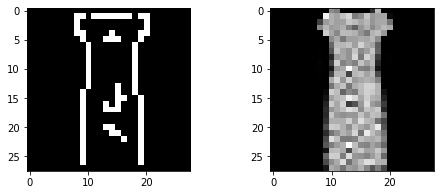

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
i = 9
ax[0].imshow(train_images_canny[i], cmap='gray')
ax[1].imshow(train_images_reshape[i], cmap='gray')
print(train_labels[i])

In [46]:
#KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, mean_squared_error

k = 8

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_images[0:60000], train_labels[0:60000])
scores = cross_val_score(knn, train_images[0:60000], train_labels[0:60000], cv=10, scoring='f1_macro', error_score="raise")
print('CV score:', scores.mean(), "+/-", scores.std())
y_pred = knn.predict(test_images)
final_score = f1_score(y_pred, test_labels, average='macro')
print(final_score)
# cf_matrix = confusion_matrix(train_labels[0:10000], y_pred[0:10000])



# color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
# x_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# y_labels = x_labels
# sns.heatmap(cf_matrix, cmap=color_pallete, center=0, square=True, annot =True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
# plt.gcf().set_size_inches(15, 10)
# plt.savefig('basic_knn_cmatrix.pdf', bbox_inches='tight')

CV score: 0.8555123253330047 +/- 0.006114795014463742
0.852424646323016


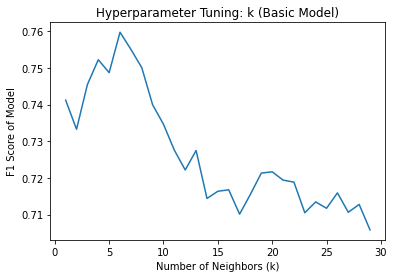

In [32]:
#Tuning K Parameter

k_lst = []
f1_lst = []

for k in range(1,30):
    k_lst.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_images[0:1000], train_labels[0:1000])
    scores = cross_val_score(knn, train_images[0:1000], train_labels[0:1000], cv=10, scoring='f1_macro', error_score="raise")
    f1_lst.append(scores.mean())

plt.plot(k_lst, f1_lst)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score of Model')
plt.title('Hyperparameter Tuning: k (Basic Model)')
plt.show
plt.savefig('tuning_k_basic.pdf', bbox_inches='tight')

In [61]:
#Logistic model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, mean_squared_error

logReg = LogisticRegressionCV(Cs=[0.001, 0.002, 0.003, 0.01, 0.1, 1, 10, 100, 1000], solver='newton-cg', cv=5, scoring="f1_macro")
logReg.fit(train_images[0:500], train_labels[0:500])

score = logReg.score(train_images, train_labels)
print(score)

y_pred = logReg.predict(test_images)
final_score = f1_score(y_pred, test_labels, average='macro')
print(final_score)

0.783498163401232
0.7742958250021476


In [35]:
# Baseline Model for Comparison
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_images, train_labels)
scores = f1_score(dummy_clf.predict(train_images), train_labels, average='macro')
print("f1_score dummy: " ,scores.mean())
scores = mean_squared_error(dummy_clf.predict(train_images), train_labels)
print("MSE_score dummy: ", scores.mean())

dummy_clf.fit(train_images_canny, train_labels[0:60000])
scores = f1_score(dummy_clf.predict(train_images), train_labels, average='macro')
print("f1_score dummy: " ,scores.mean())
scores = mean_squared_error(dummy_clf.predict(train_images), train_labels)
print("MSE_score dummy: ", scores.mean())

f1_score dummy:  0.01818181818181818
MSE_score dummy:  28.5
f1_score dummy:  0.01818181818181818
MSE_score dummy:  28.5


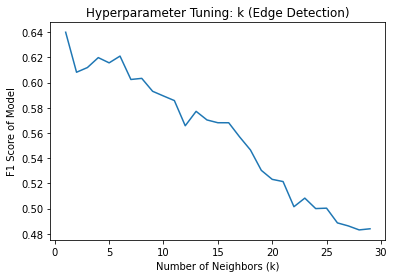

In [36]:
#Tuning K Parameter - Canny Model
train_images_canny = np.reshape(train_images_canny, (len(train_images_canny), 28*28))

k_lst = []
f1_lst = []

for k in range(1,30):
    k_lst.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_images_canny[0:1000], train_labels[0:1000])
    scores = cross_val_score(knn, train_images_canny[0:1000], train_labels[0:1000], cv=10, scoring='f1_macro', error_score="raise")
    f1_lst.append(scores.mean())

plt.plot(k_lst, f1_lst)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score of Model')
plt.title('Hyperparameter Tuning: k (Edge Detection)')
plt.show
plt.savefig('tuning_k_canny.pdf', bbox_inches='tight')

In [55]:
#KNN model - Canny
train_images_canny = np.reshape(train_images_canny, (len(train_images_canny), 28*28))
test_images_canny = np.reshape(test_images_canny, (len(test_images_canny), 28*28))

k = 5

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_images_canny[0:60000], train_labels[0:60000])
scores = cross_val_score(knn, train_images_canny[0:60000], train_labels[0:60000], cv=10, scoring='f1_macro', error_score="raise")
print('CV score:', scores.mean(), "+/-", scores.std())
# y_pred = knn.predict(train_images_canny[0:60000])
# cf_matrix = confusion_matrix(train_labels[0:60000], y_pred)

y_pred = knn.predict(test_images_canny)
final_score = f1_score(y_pred, test_labels, average='macro')
print(final_score)

#PLT Heatmap
# color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
# x_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# y_labels = x_labels
# sns.heatmap(cf_matrix, cmap=color_pallete, center=0, square=True, annot =True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
# plt.gcf().set_size_inches(15, 10)
# plt.savefig('canny_knn_cmatrix.pdf', bbox_inches='tight')

CV score: 0.804531507269879 +/- 0.005321997459865284
0.8011034707637258


In [60]:
#Logistic model - Canny
train_images_canny = np.reshape(train_images_canny, (len(train_images_canny),28*28))

logReg = LogisticRegressionCV(Cs=[0.001, 0.002, 0.003, 0.01, 0.1, 1, 10, 100, 1000], solver='newton-cg', cv=5, scoring="f1_macro")
logReg.fit(train_images_canny[0:500], train_labels[0:500])

score = logReg.score(train_images_canny, train_labels[0:60000])
print(score)

y_pred = logReg.predict(test_images_canny)
final_score = f1_score(y_pred, test_labels, average='macro')
print(final_score)

0.6922436279298049
0.6788915463831842


In [39]:
#Tuning K Parameter - Combined Model

k_lst = []
f1_lst = []

for k in range(1,30):
    k_lst.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_images_combine[0:1000], train_labels[0:1000])
    scores = cross_val_score(knn, train_images_combine[0:1000], train_labels[0:1000], cv=10, scoring='f1_macro', error_score="raise")
    f1_lst.append(scores.mean())

# plt.plot(k_lst, f1_lst)
# plt.xlabel('Number of Neighbors (k)')
# plt.ylabel('F1 Score of Model')
# plt.title('Hyperparameter Tuning: k (Edge Detection)')
# plt.show
# plt.savefig('tuning_k_combine.pdf', bbox_inches='tight')

In [56]:
#Combining Canny and Basic

train_images_canny = np.reshape(train_images_canny, (len(train_images_canny), 28*28))
train_images_combine = np.concatenate((train_images_canny, train_images[0:60000]), axis=1)
test_images_combine = np.concatenate((test_images_canny, test_images[0:10000]), axis=1)

k = 5

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_images_combine, train_labels[0:60000])
scores = cross_val_score(knn, train_images_combine[0:60000], train_labels[0:60000], cv=10, scoring='f1_macro', error_score="raise")
print('CV score:', scores.mean(), "+/-", scores.std())
# y_pred = knn.predict(train_images_combine[0:60000])
# cf_matrix = confusion_matrix(train_labels[0:10000], y_pred[0:10000])
y_pred = knn.predict(test_images_combine)
final_score = f1_score(y_pred, test_labels, average='macro')
print(final_score)

#PLT Heatmap
# color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
# x_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# y_labels = x_labels
# sns.heatmap(cf_matrix, cmap=color_pallete, center=0, square=True, annot =True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
# plt.gcf().set_size_inches(15, 10)
# plt.savefig('combined_knn_cmatrix.pdf', bbox_inches='tight')

CV score: 0.8550940472160405 +/- 0.005217480609303425
0.8546439722018905


In [59]:
#Logistic model - Combined

logReg = LogisticRegressionCV(Cs=[0.001, 0.002, 0.003, 0.01, 0.1, 1, 10, 100, 1000], solver='newton-cg', cv=5, scoring="f1_macro")
logReg.fit(train_images_combine[0:500], train_labels[0:500])

score = logReg.score(train_images_combine, train_labels[0:60000])
print(score)

y_pred = logReg.predict(test_images_combine)
final_score = f1_score(y_pred, test_labels, average='macro')
print(final_score)


0.7834975512447191
0.7743912142714162
